1. Получение данных.
    * Визуализация первых десяти изображений.

Эта лабораторная работа посвящена кластеризации. Мы будем работать с изображениями лиц, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `fetch_lfw_people`. Всего имеется 1456 наблюдений, каждое из них представляет чёрно-белую картинку 62 $\times$ 47 пикселей. Эти картинки – лица людей. Картинок на каждый класс дано приблизительно поровну, около 53.

Для удобства использования данных каждая картинка "развёрнута" в строку, так, что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1456 $\times$ 2914. Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 255.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: кому принадлежит лицо с картинки. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать людей по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. люди) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одних и тех же людей.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1456 $\times$ 2914 числа, а в переменной `y` – массив истинных меток классов, содержащий 1456 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `fetch_lfw_people`.
- Размер массива хранится в атрибуте `shape`.

In [2]:
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_lfw_people
from sklearn.manifold import TSNE
from random import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

from clust_utils import plot_faces, group_mean, get_metrics


In [2]:
# load faces dataset
faces = fetch_lfw_people(min_faces_per_person=53)
X = faces.data
y = faces.target

print(faces.images.shape, X.shape, y.shape)


(1456, 62, 47) (1456, 2914) (1456,)


Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). 

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 62 $\times$ 47 можно либо достать готовыми из объекта, загруженного функцией `fetch_lfw_people`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 255 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

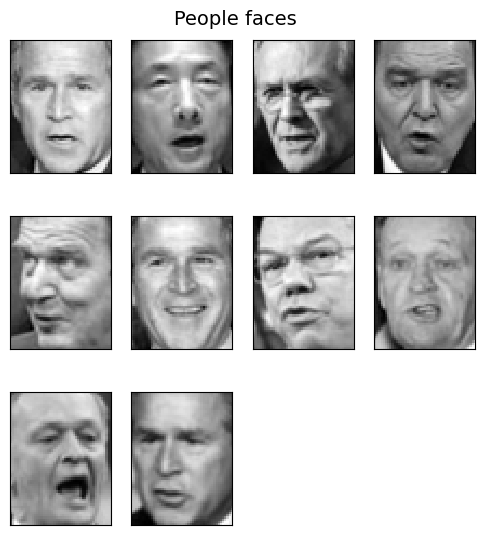

In [3]:
# visualize first 10 faces
plot_faces(faces.data, faces.images.shape[1:], 'People faces', interpolation='none')


2. Кластеризация и оценка качества.
    * Визуализизация центров кластеров.
    * Анализ зависимости метрик от числа кластеров.

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1456 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [4]:
# make hierarhical clustering with AgglomerativeClustering
n = 10
hierarhical_clusterizer = AgglomerativeClustering(n_clusters=n)
pred_h = hierarhical_clusterizer.fit_predict(X)

print(pred_h.shape)


(1456,)


In [5]:
# make hierarhical clustering with KMeand
kmeans_clusterizer = KMeans(n, n_init=100)
pred_kmeans = kmeans_clusterizer.fit_predict(X)

print(pred_kmeans.shape)


(1456,)


Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные правильные?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [6]:
# visualize clusters
def visualize_clusters(data_x, groups_x, pred_y, cell: int, title: str):
    plt.figure(figsize=(10, 20))
    plt.subplot(3, 1, cell)
    plt.title(title)

    # draw datset points
    sb.scatterplot(x=data_x[:, 0], y=data_x[:, 1], 
                   hue=pred_y, s=5,
                   palette='hls', legend=False)

    # draw clusters
    sb.scatterplot(x=groups_x[:, 0], y=groups_x[:, 1], 
                   hue=np.sort(np.unique(pred_y)), s=100,
                   palette='hls', legend='full')


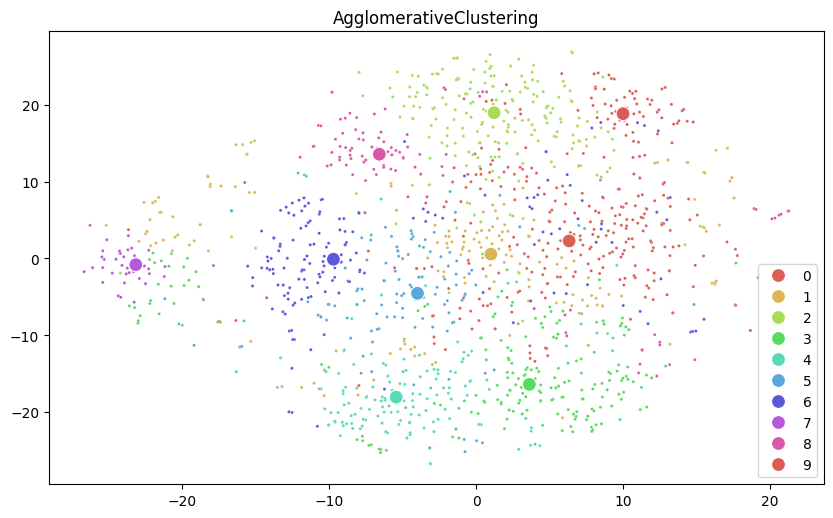

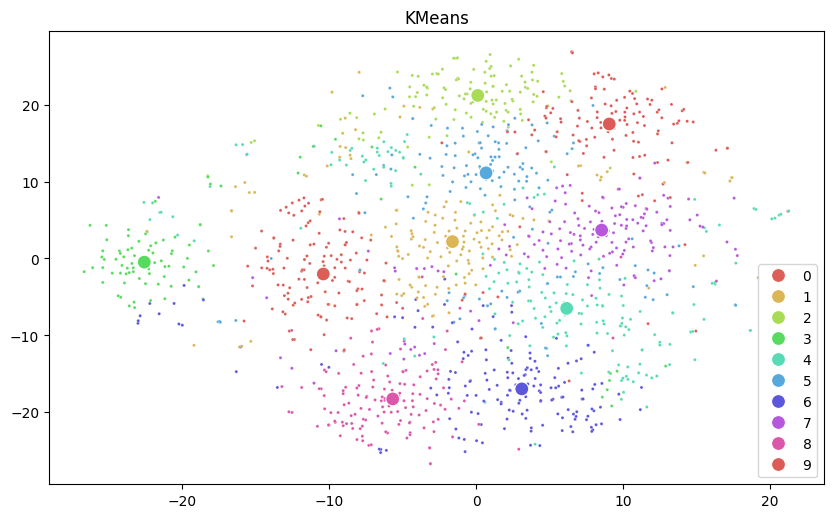

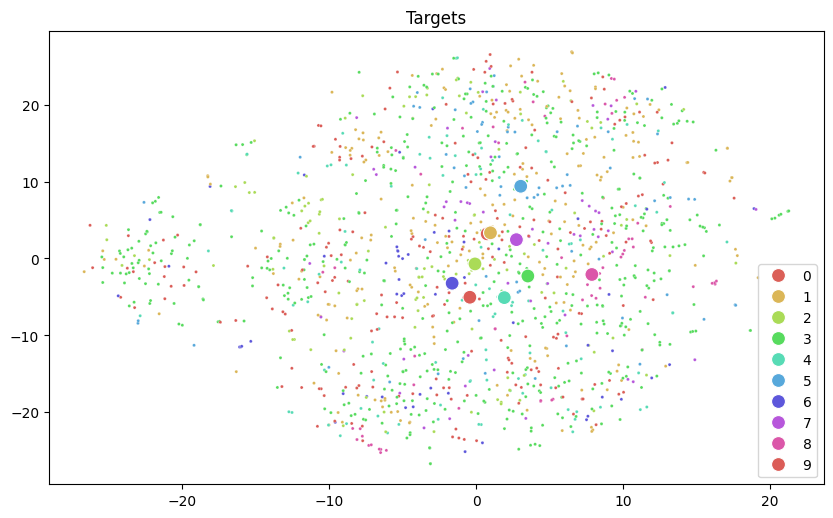

In [7]:
# visualize clusters from two methods
tsne = TSNE(n_components=2)

pred_groups_h = group_mean(X, pred_h)
pred_groups_kmeans = group_mean(X, pred_kmeans)
groups_targets = group_mean(X, y)

stacked_array = np.vstack([X, pred_groups_h, pred_groups_kmeans, groups_targets])
res_array = tsne.fit_transform(stacked_array)

x_transformed, x_groups_h, x_groups_kmeans, x_groups_targets = \
    res_array[:-30], res_array[-30:-20], res_array[-20:-10], res_array[-10:]

visualize_clusters(x_transformed, x_groups_h, pred_h, 1, 'AgglomerativeClustering')
visualize_clusters(x_transformed, x_groups_kmeans, pred_kmeans, 2, 'KMeans')
visualize_clusters(x_transformed, x_groups_targets, y, 3, 'Targets')


Вывод:<br>
По графикам видно, что для обоих методов примерно совпадает около половины центров кластеров, однако заметное кол-во точек отнесено к различным кластерам разными методами. При чем в итоге ни один из методов не приблиился к целевому расположению центров кластеров.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [ ]:
# calculate silhouette and v-mesure scores for two methods
kmeans_silhouette_scores, kmeans_vmeasure = get_metrics(2, 20, KMeans, X, y)
h_silhouette_scores, h_vmeasure = get_metrics(2, 20, AgglomerativeClustering, X, y)


In [10]:
# visualize silhouette scores with clusters number
def visualize_scores(y, cell: int, title: str, x=range(2, 21), y_label: str='Silhouette', x_label: str='Clusters'):
    major_locator_y = 0.01

    plt.figure(figsize=(6, 12))
    plt.subplot(2, 1, cell)
    plt.title(title)

    plt.grid()
    plt.ylabel(f'{y_label} score')
    plt.xlabel(f'{x_label} number')

    plt.gca().set_ylim(0, (int(max(y) / major_locator_y) + 1) * major_locator_y)
    plt.gca().set_xlim(0, 21)

    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(major_locator_y))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

    plt.plot(x, y, marker='o', markersize=5, color=(random(), random(), random()))


KMEANS
	Maximum silhouette score is achived with 2 clusters: 0.11443189
AGGLOMERATIVECLUSTERING
	Maximum silhouette score is achived with 2 clusters: 0.107611164


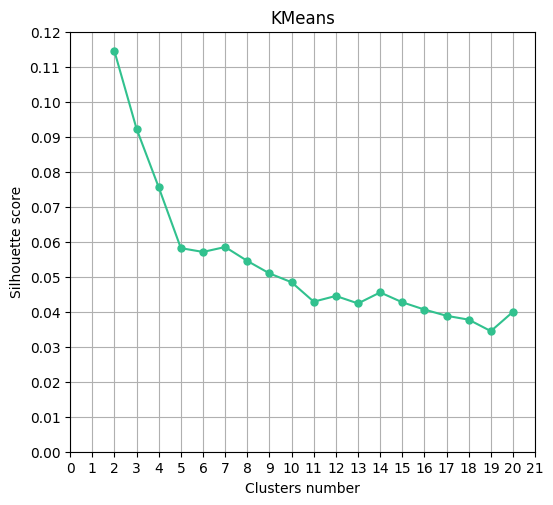

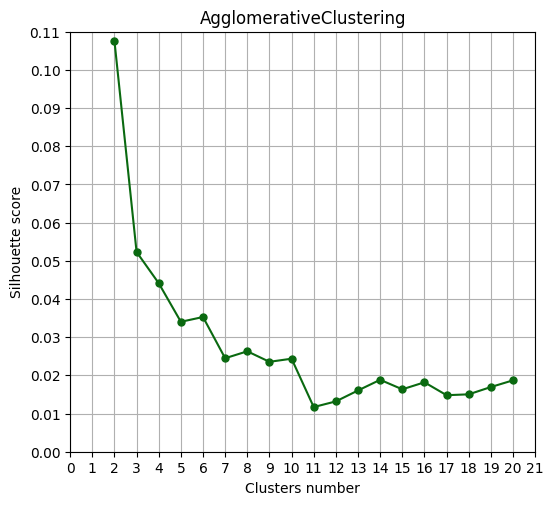

In [11]:
visualize_scores(kmeans_silhouette_scores, 1, 'KMeans')
kmeans_s2914 = np.max(kmeans_silhouette_scores)
print('KMEANS\n\tMaximum silhouette score is achived with', np.argmax(kmeans_silhouette_scores) + 2, 'clusters:', kmeans_s2914)

visualize_scores(h_silhouette_scores, 2, 'AgglomerativeClustering')
h_s2914 = np.max(h_silhouette_scores)
print('AGGLOMERATIVECLUSTERING\n\tMaximum silhouette score is achived with', np.argmax(h_silhouette_scores) + 2, 'clusters:', h_s2914)


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какое лицо на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

KMEANS
	Maximum V-measure score is achived with 20 clusters: 0.07017014009908581
AGGLOMERATIVECLUSTERING
	Maximum V-measure score is achived with 20 clusters: 0.06639373514607072


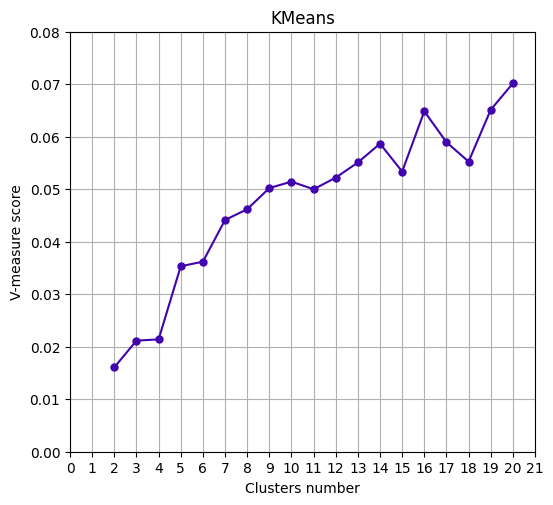

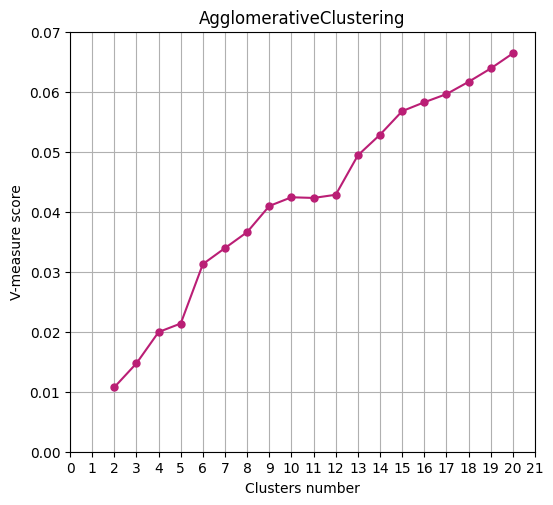

In [12]:
visualize_scores(kmeans_vmeasure, 1, 'KMeans', y_label='V-measure')
kmeans_v2914 = np.max(kmeans_vmeasure)
print('KMEANS\n\tMaximum V-measure score is achived with', np.argmax(kmeans_vmeasure) + 2, 'clusters:', kmeans_v2914)

visualize_scores(h_vmeasure, 2, 'AgglomerativeClustering', y_label='V-measure')
h_v2914 = np.max(h_vmeasure)
print('AGGLOMERATIVECLUSTERING\n\tMaximum V-measure score is achived with', np.argmax(h_vmeasure) + 2, 'clusters:', h_v2914)


In [18]:
# save best combinations to DataFrame
metrics_df = pd.DataFrame(dict(zip(['Method', 'N clusters', 'N features', 'Silhouette', 'V-measure'], 
                                   [['KMeans', 'AgglomerativeClustering'] * 2, 
                                    [np.argmax(kmeans_silhouette_scores) + 2, np.argmax(h_silhouette_scores) + 2, 
                                     np.argmax(kmeans_vmeasure) + 2, np.argmax(h_vmeasure) + 2], 
                                    [X.shape[1]] * 4, [kmeans_s2914, h_s2914, 0, 0], [0, 0, kmeans_v2914, h_v2914]])))


3. Снижение размерности признакового пространства.

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [14]:
# calculate silhuette and v-measure scores for different feature numbers
n_features = [2, 5, 10, 20]

silhouette_scores_n = list()        # [kmeans scores, hierarhical scores]
vmeasure_scores_n = list()          # [kmeans scores, hierarhical scores]

for n in tqdm(n_features):
    trunc_svd = TruncatedSVD(n_components=n)
    new_x = trunc_svd.fit_transform(X)

    kmeans_pred = kmeans_clusterizer.fit_predict(new_x)
    hierarhical_pred = hierarhical_clusterizer.fit_predict(new_x)

    silhouette_scores_n.append([silhouette_score(new_x, kmeans_pred), silhouette_score(new_x, hierarhical_pred)])
    vmeasure_scores_n.append([v_measure_score(y, kmeans_pred), v_measure_score(y, hierarhical_pred)])

silhouette_scores_n = np.array(silhouette_scores_n)
vmeasure_scores_n = np.array(vmeasure_scores_n)


100%|██████████| 4/4 [00:34<00:00,  8.71s/it]


KMEANS
	Maximum silhouette score is achived with 2 features: 0.32535198
AGGLOMERATIVECLUSTERING
	Maximum silhouette score is achived with 2 features: 0.26889366


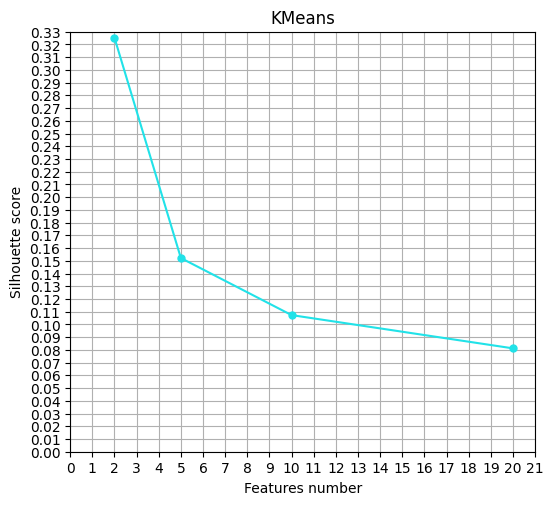

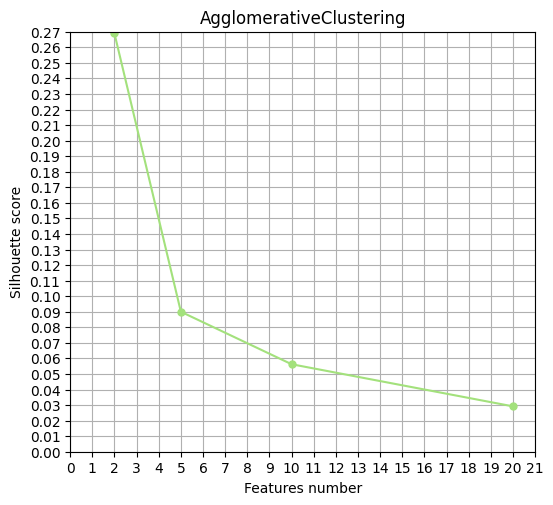

In [15]:
kmeans_silhouette_max_n, h_silhouette_max_n = np.argmax(silhouette_scores_n, axis=0)
kmeans_s2 = silhouette_scores_n[kmeans_silhouette_max_n, 0]
h_s2 = silhouette_scores_n[kmeans_silhouette_max_n, 1]

visualize_scores(silhouette_scores_n[:, 0], 1, 'KMeans', x=n_features, x_label='Features')
print('KMEANS\n\tMaximum silhouette score is achived with', n_features[kmeans_silhouette_max_n], 'features:', kmeans_s2)

visualize_scores(silhouette_scores_n[:, 1], 2, 'AgglomerativeClustering', x=n_features, x_label='Features')
print('AGGLOMERATIVECLUSTERING\n\tMaximum silhouette score is achived with', n_features[h_silhouette_max_n], 'features:', h_s2)


KMEANS
	Maximum V-measure score is achived with 10 features: 0.05052401613237223
AGGLOMERATIVECLUSTERING
	Maximum V-measure score is achived with 5 features: 0.04947794571545138


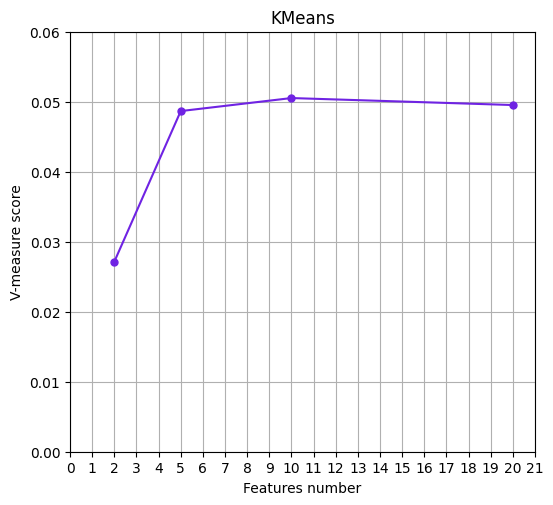

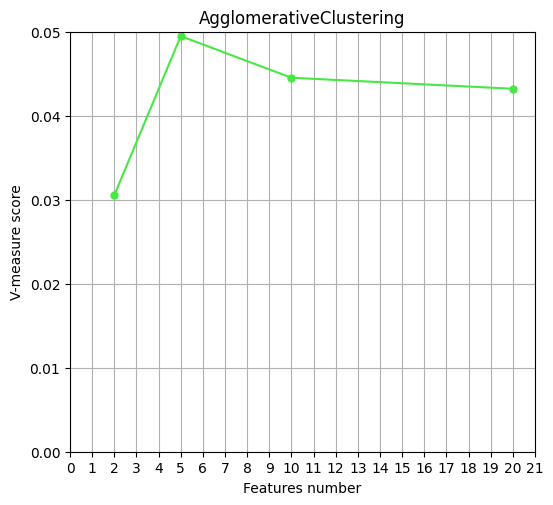

In [16]:
kmeans_vmeasure_max_n, h_vmeasure_max_n = np.argmax(vmeasure_scores_n, axis=0)
kmeans_v10 = vmeasure_scores_n[kmeans_vmeasure_max_n, 0]
h_v5 = vmeasure_scores_n[h_vmeasure_max_n, 1]

visualize_scores(vmeasure_scores_n[:, 0], 1, 'KMeans', x=n_features, x_label='Features', y_label='V-measure')
print('KMEANS\n\tMaximum V-measure score is achived with', n_features[kmeans_vmeasure_max_n], 'features:', kmeans_v10)

visualize_scores(vmeasure_scores_n[:, 1], 2, 'AgglomerativeClustering', x=n_features, x_label='Features', y_label='V-measure')
print('AGGLOMERATIVECLUSTERING\n\tMaximum V-measure score is achived with', n_features[h_vmeasure_max_n], 'features:', h_v5)


In [24]:
# save best combinations to DataFrame
metrics_df = metrics_df._append(pd.DataFrame(dict(zip(metrics_df.columns, 
                                                      [['KMeans', 'AgglomerativeClustering'] * 2, [10] * 4, 
                                                       [n_features[kmeans_silhouette_max_n], n_features[h_silhouette_max_n], 
                                                        n_features[kmeans_vmeasure_max_n], n_features[h_vmeasure_max_n]], 
                                                       [kmeans_s2, h_s2, 0, 0], [0, 0, kmeans_v10, h_v5]]))), 
                                                       ignore_index=True)
metrics_df = metrics_df.sort_values(by='Method', ascending=False)
metrics_df


,Method,N clusters,N features,Silhouette,V-measure
0,KMeans,2,2914,0.114432,0.000000
2,KMeans,20,2914,0.000000,0.070170
4,KMeans,10,2,0.325352,0.000000
6,KMeans,10,10,0.000000,0.050524
1,AgglomerativeClustering,2,2914,0.107611,0.000000
3,AgglomerativeClustering,20,2914,0.000000,0.066394
5,AgglomerativeClustering,10,2,0.268894,0.000000
7,AgglomerativeClustering,10,5,0.000000,0.049478


Вывод:<br>
По данным выше видно, что для обоих методов при 10ти кластерах и двух признаках удалось получить значение Silhouette score выше, чем у остальных комбинаций.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

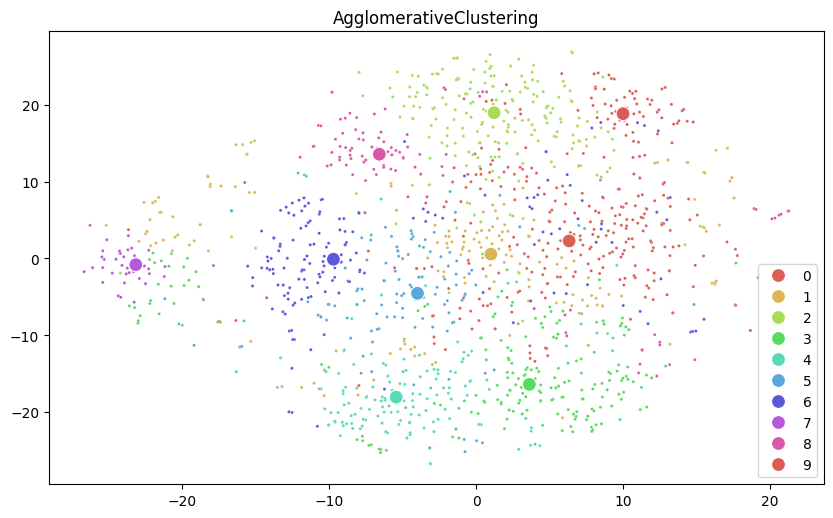

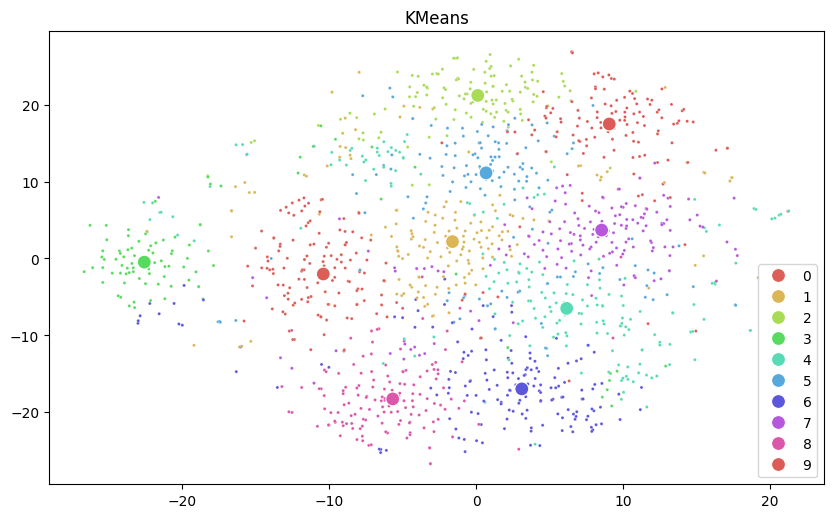

In [25]:
visualize_clusters(x_transformed, x_groups_h, pred_h, 1, 'AgglomerativeClustering')
visualize_clusters(x_transformed, x_groups_kmeans, pred_kmeans, 2, 'KMeans')


Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [26]:
# calculate silhouette and v-measure scores for two methods
kmeans_pred = kmeans_clusterizer.fit_predict(x_transformed)
hierarhical_pred = hierarhical_clusterizer.fit_predict(x_transformed)

kmeans_s_transformed2 = silhouette_score(x_transformed, kmeans_pred)
h_s_transformed2 = silhouette_score(x_transformed, hierarhical_pred)

kmeans_v_transformed2 = v_measure_score(y, kmeans_pred)
h_v_transformed2 = v_measure_score(y, hierarhical_pred)


In [27]:
# save combinations to DataFrame
metrics_df = metrics_df._append(pd.DataFrame(dict(zip(metrics_df.columns, 
                                                      [['KMeans', 'AgglomerativeClustering'], [10] * 2, [2] * 2, 
                                                       [kmeans_s_transformed2, h_s_transformed2], [kmeans_v_transformed2, h_v_transformed2]]))), 
                                                       ignore_index=True)
metrics_df = metrics_df.sort_values(by='Method', ascending=False)
metrics_df

,Method,N clusters,N features,Silhouette,V-measure
0,KMeans,2,2914,0.114432,0.000000
1,KMeans,20,2914,0.000000,0.070170
2,KMeans,10,2,0.325352,0.000000
3,KMeans,10,10,0.000000,0.050524
8,KMeans,10,2,0.381680,0.049401
4,AgglomerativeClustering,2,2914,0.107611,0.000000
5,AgglomerativeClustering,20,2914,0.000000,0.066394
6,AgglomerativeClustering,10,2,0.268894,0.000000
7,AgglomerativeClustering,10,5,0.000000,0.049478
9,AgglomerativeClustering,10,2,0.328265,0.043732


Вывод:<br>
По данным выше видно, что для обоих методов при 10ти кластерах и двух признаках удалось получить только значение Silhouette score выше, чем у остальных комбинаций.

Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какому-нибудь одному лицу?

Вывод:<br>
Лучшим разбиением по метрике Silhouette score для обоих методов оказался последний вариант: при 10ти кластерах и двух признаках. Однако по картинкам ниже видно, что результаты обоих методов далеки от целевых кластеров.

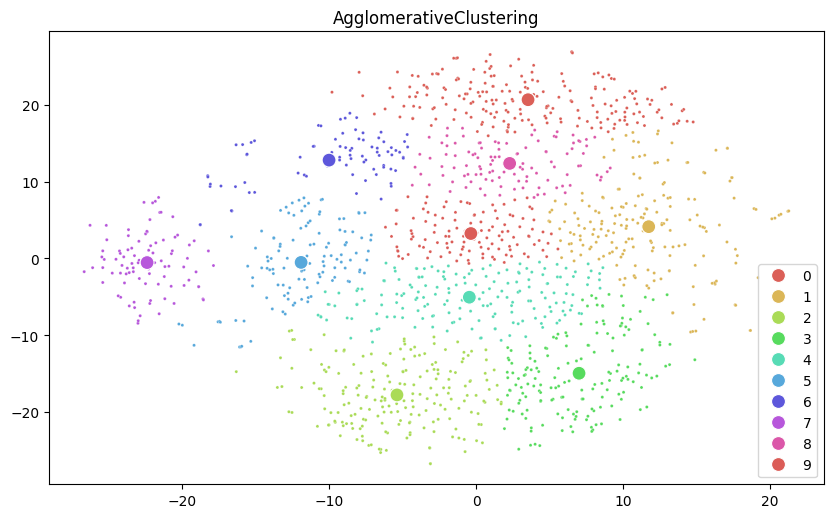

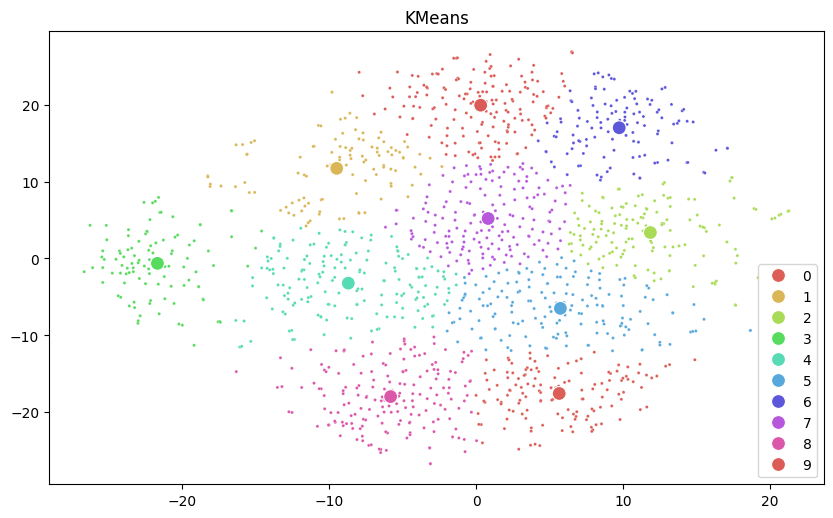

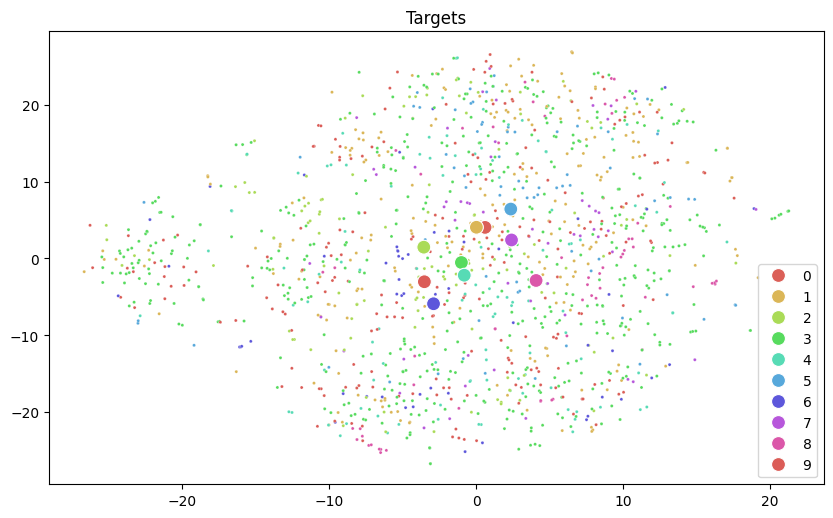

In [30]:
# visualize clusters from two methods
best_groups_h = group_mean(x_transformed, hierarhical_pred)
best_groups_kmeans = group_mean(x_transformed, kmeans_pred)
target_groups = group_mean(x_transformed, y)

visualize_clusters(x_transformed, best_groups_h, hierarhical_pred, 1, 'AgglomerativeClustering')
visualize_clusters(x_transformed, best_groups_kmeans, kmeans_pred, 2, 'KMeans')
visualize_clusters(x_transformed, target_groups, y, 3, 'Targets')


4. Выводы.

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

In [3]:
metrics_df


,Method,N clusters,N features,Silhouette,V-measure
0,KMeans,2,2914,0.114432,0.000000
1,KMeans,20,2914,0.000000,0.070170
2,KMeans,10,2,0.325352,0.000000
3,KMeans,10,10,0.000000,0.050524
4,KMeans,10,2,0.381680,0.049401
5,AgglomerativeClustering,2,2914,0.107611,0.000000
6,AgglomerativeClustering,20,2914,0.000000,0.066394
7,AgglomerativeClustering,10,2,0.268894,0.000000
8,AgglomerativeClustering,10,5,0.000000,0.049478
9,AgglomerativeClustering,10,2,0.328265,0.043732


Вывод:<br>
Как видно из визуализации кластеров выше, оба метода дают похожие разбиения на кластеры, однако по метрике Silhouette score лучшее разбиение получилось методом KMeans с 10ью кластерами и 2 признаками (после применения TSNE). По значениям V-measure score лучше всего отработал метод KMeans с 20ью кластерами и первоначальным набором признаков. Следовательно, результат зависит от настроек алгоритма (кол-ва кластеров). <br>
Из таблицы выше видно, что по различным метрикам получаются разные результаты для одних и тех же наборов параметров, следовательно, критерии и метрики, по которым оценивается качество, тоже влияют на выбор метода.<br>
По значениям Silhouette score можно увидеть, что наилучшие показатели качества были при использовании двух признаков (после применения TSNE), поэтому снижение разметности признакового пространства дает улучшение по качеству.